In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Plot the performance by method
sns.set_theme(context="notebook", style="whitegrid")

In [ ]:
def load_from_path(data_path: Path):
    crop_perfs = []

    for mode in ["attention", "max_pooler"]:
        train_metrics = pd.read_csv(
            data_path / ("mode=" + mode) / "combined_model" / "final_train_metrics.csv"
        )
        mode_string = mode.replace("_", " ").title()
        for i, row in train_metrics.iterrows():
            crop = row["crop_slug"].replace("_", " ").title()
            crop_perfs.append(
                {
                    "title": f"{crop} ({mode_string} combined)",
                    "crop": crop,
                    "presence_f1": row["presence_f1"],
                    "rmse_if_present": row["rmse_if_present"],
                    "pooling_method": mode,
                    "training_method": "combined",
                }
            )

        single_models_path = data_path / ("mode=" + mode) / "single_models"
        for single_model_path in single_models_path.iterdir():
            if not (single_model_path / "final_train_metrics.csv").exists():
                continue
            train_metrics = pd.read_csv(single_model_path / "final_train_metrics.csv")

            row = train_metrics.iloc[0]
            crop = row["crop_slug"].replace("_", " ").title()
            crop_perfs.append(
                {
                    "title": f"{crop} ({mode_string} single)",
                    "crop": crop,
                    "presence_f1": row["presence_f1"],
                    "rmse_if_present": row["rmse_if_present"],
                    "pooling_method": mode,
                    "training_method": "single",
                }
            )

    return crop_perfs


# crop_perfs = pd.DataFrame(load_from_path(Path("../out/2024-11-24_08-10-20_all-training")))
crop_perfs = pd.DataFrame(load_from_path(Path("../out/2024-11-24_16-50-28")))

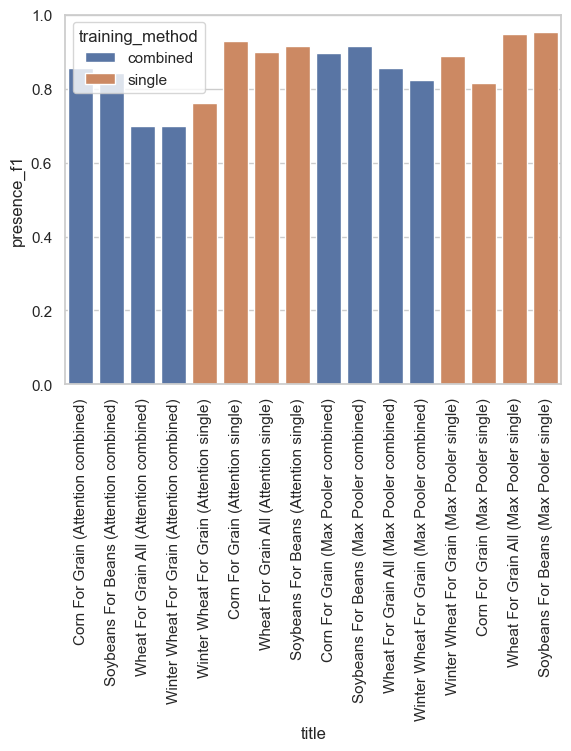

In [ ]:
sns.barplot(data=crop_perfs, x="title", y="presence_f1", hue="training_method")
plt.xticks(rotation=90)

plt.show()

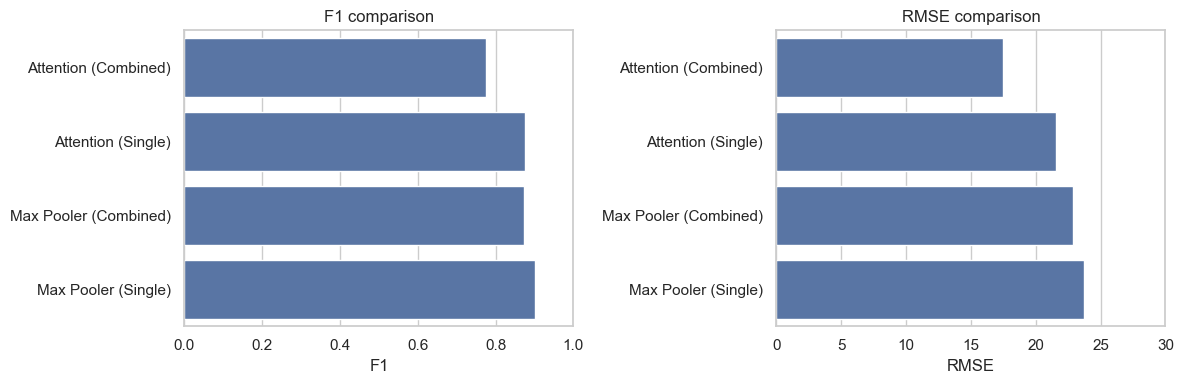

In [ ]:
# compare average f1 for each approach

approach_scores = []

for pooling_method_name, pooling_method_df in crop_perfs.groupby("pooling_method"):
    for training_method_name, training_method_df in pooling_method_df.groupby(
        "training_method"
    ):
        result = training_method_df[["presence_f1", "rmse_if_present"]].mean(axis=0)
        title = f"{pooling_method_name} ({training_method_name})"
        title = title.replace("_", " ").title()
        approach_scores.append(
            {
                "title": title,
                "pooling_method": pooling_method_name,
                "training_method": training_method_name,
                "presence_f1": result["presence_f1"],
                "rmse": result["rmse_if_present"],
            }
        )

approach_scores = pd.DataFrame(approach_scores)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("F1 comparison")
sns.barplot(approach_scores, y="title", x="presence_f1", orient="h")
plt.xlabel("F1")
plt.ylabel("")
plt.xlim(0, 1)

plt.subplot(1, 2, 2)
plt.title("RMSE comparison")
sns.barplot(approach_scores, y="title", x="rmse", orient="h")
plt.xlabel("RMSE")
plt.ylabel("")
plt.xlim(0, 30)
plt.tight_layout()

plt.show()

In [30]:
approach_scores

,title,pooling_method,training_method,presence_f1,rmse
0,Attention (Combined),attention,combined,0.774812,17.481279
1,Attention (Single),attention,single,0.876786,21.569996
2,Max Pooler (Combined),max_pooler,combined,0.873473,22.848847
3,Max Pooler (Single),max_pooler,single,0.900863,23.685559


## Plotting Per-Crop Performance

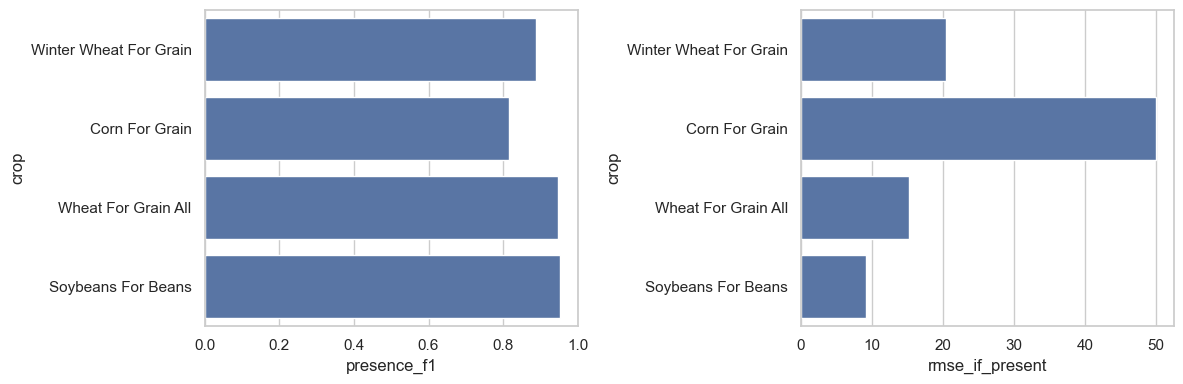

In [ ]:
max_pooler_single = crop_perfs[
    (crop_perfs["pooling_method"] == "max_pooler")
    & (crop_perfs["training_method"] == "single")
]
max_pooler_single.loc[:, "crop"] = max_pooler_single["crop"].map(
    lambda c: "Hemp" if "Hemp" in c else c
)

plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(
    max_pooler_single,
    x="presence_f1",
    y="crop",
    orient="h",
)
plt.subplot(1, 2, 2)
sns.barplot(
    max_pooler_single,
    x="rmse_if_present",
    y="crop",
    orient="h",
)
plt.tight_layout()
plt.show()

In [22]:
crop_perfs

,title,crop,presence_f1,rmse_if_present,pooling_method,training_method
0,Corn For Grain (Attention combined),Corn For Grain,0.857143,44.766323,attention,combined
1,Soybeans For Beans (Attention combined),Soybeans For Beans,0.842105,7.659291,attention,combined
2,Wheat For Grain All (Attention combined),Wheat For Grain All,0.700000,9.630048,attention,combined
3,Winter Wheat For Grain (Attention combined),Winter Wheat For Grain,0.700000,7.869453,attention,combined
4,Winter Wheat For Grain (Attention single),Winter Wheat For Grain,0.761905,18.671034,attention,single
5,Corn For Grain (Attention single),Corn For Grain,0.928571,41.493027,attention,single
6,Wheat For Grain All (Attention single),Wheat For Grain All,0.900000,19.071798,attention,single
7,Soybeans For Beans (Attention single),Soybeans For Beans,0.916667,7.044126,attention,single
8,Corn For Grain (Max Pooler combined),Corn For Grain,0.896552,38.035954,max_pooler,combined
9,Soybeans For Beans (Max Pooler combined),Soybeans For Beans,0.916667,14.078078,max_pooler,combined


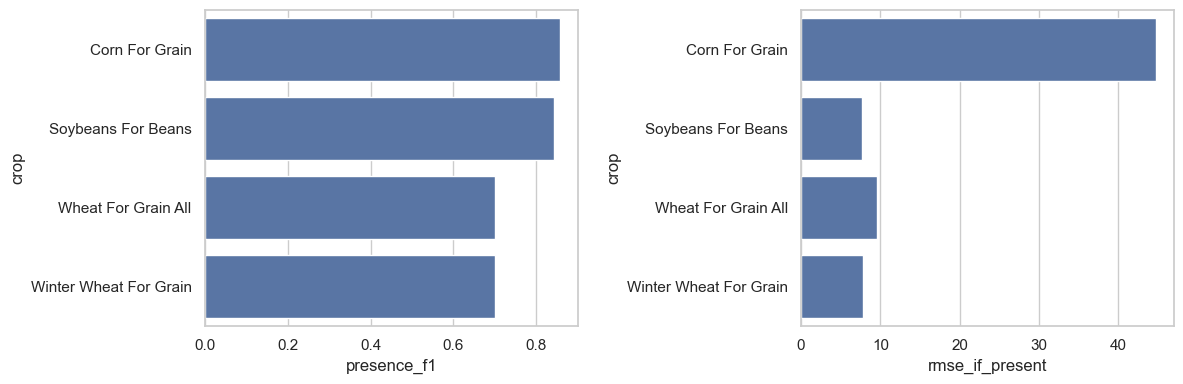

In [ ]:
attention_pooler_combined = crop_perfs[
    (crop_perfs["pooling_method"] == "attention")
    & (crop_perfs["training_method"] == "combined")
]
attention_pooler_combined.loc[:, "crop"] = attention_pooler_combined["crop"].map(
    lambda c: "Hemp" if "Hemp" in c else c
)

plt.subplots(1, 2, figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(
    attention_pooler_combined,
    x="presence_f1",
    y="crop",
    orient="h",
)
plt.subplot(1, 2, 2)
sns.barplot(
    attention_pooler_combined,
    x="rmse_if_present",
    y="crop",
    orient="h",
)
plt.tight_layout()
plt.show()

In [ ]:
max_pooler_single[["crop", "presence_f1"]]

,crop,presence_f1
12,Winter Wheat For Grain,0.888889
13,Corn For Grain,0.814815
14,Wheat For Grain All,0.947368
15,Soybeans For Beans,0.952381


In [ ]:
baseline_rmse = [
    ["Corn For Grain", 29.60],
    ["Winter Wheat For Grain", 10.95],
    ["Wheat For Grain All", 11.19],
    ["Soybeans For Beans", 9.89],
]

_ = attention_pooler_combined[["crop", "rmse_if_present"]]
_.columns = ["crop", "rmse"]
_.loc[:, "baseline_rmse"] = [b for (a, b) in baseline_rmse]
_

/var/folders/pt/45xmzdh176jcsmxv9vb4by_c0000gn/T/ipykernel_81563/839831834.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _.loc[:, 'baseline_rmse'] = [b for (a,b) in baseline_rmse]


,crop,rmse,baseline_rmse
0,Corn For Grain,44.766323,29.60
1,Soybeans For Beans,7.659291,10.95
2,Wheat For Grain All,9.630048,11.19
3,Winter Wheat For Grain,7.869453,9.89


## Visualizing Data Distribution

In [2]:
df = pd.read_csv("../data/va_crops_2022.csv")

In [ ]:
for c in [
    "winter_wheat_for_grain",
    "corn_for_grain",
    "wheat_for_grain_all",
    "soybeans_for_beans",
]:
    series = df[c]
    print(c, series[~series.isna()].std())

winter_wheat_for_grain 10.954866880700726
corn_for_grain 29.602836493265933
wheat_for_grain_all 11.185881049284424
soybeans_for_beans 9.886839550221525


In [ ]:
df["corn_for_grain"]

0     138.780952
1     137.789256
2            NaN
3     141.980594
4            NaN
         ...    
92    107.227660
93    170.616976
94           NaN
95     96.276127
96           NaN
Name: corn_for_grain, Length: 97, dtype: float64

array([[<Axes: xlabel='winter_wheat_for_grain', ylabel='winter_wheat_for_grain'>,
        <Axes: xlabel='corn_for_grain', ylabel='winter_wheat_for_grain'>,
        <Axes: xlabel='wheat_for_grain_all', ylabel='winter_wheat_for_grain'>,
        <Axes: xlabel='soybeans_for_beans', ylabel='winter_wheat_for_grain'>],
       [<Axes: xlabel='winter_wheat_for_grain', ylabel='corn_for_grain'>,
        <Axes: xlabel='corn_for_grain', ylabel='corn_for_grain'>,
        <Axes: xlabel='wheat_for_grain_all', ylabel='corn_for_grain'>,
        <Axes: xlabel='soybeans_for_beans', ylabel='corn_for_grain'>],
       [<Axes: xlabel='winter_wheat_for_grain', ylabel='wheat_for_grain_all'>,
        <Axes: xlabel='corn_for_grain', ylabel='wheat_for_grain_all'>,
        <Axes: xlabel='wheat_for_grain_all', ylabel='wheat_for_grain_all'>,
        <Axes: xlabel='soybeans_for_beans', ylabel='wheat_for_grain_all'>],
       [<Axes: xlabel='winter_wheat_for_grain', ylabel='soybeans_for_beans'>,
        <Axes: xlabel='c

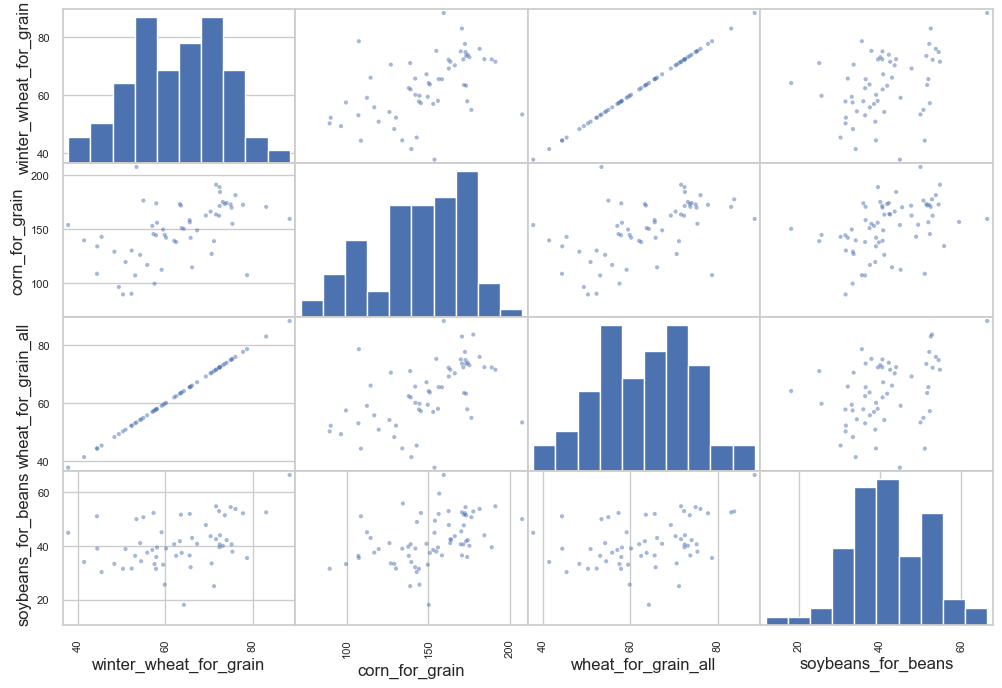

In [ ]:
from pandas.plotting import scatter_matrix

attributes = [
    "winter_wheat_for_grain",
    "corn_for_grain",
    "wheat_for_grain_all",
    "soybeans_for_beans",
]
scatter_matrix(df[attributes], figsize=(12, 8))

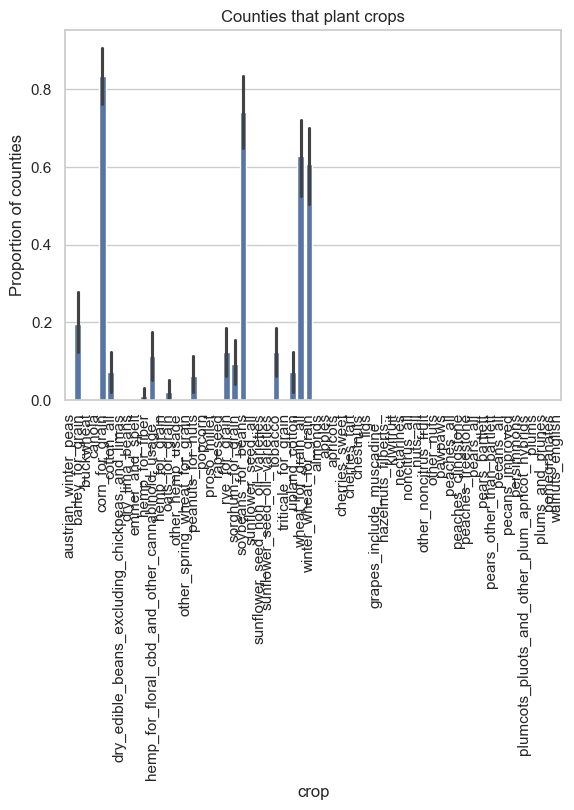

In [27]:
C = [
    "winter_wheat_for_grain",
    "corn_for_grain",
    "wheat_for_grain_all",
    "soybeans_for_beans",
]

nas = pd.DataFrame(
    sum(
        [
            [{"crop": k, "found": ~np.isnan(df.loc[i, k])} for i in range(len(df))]
            for k in df.columns if k != 'county'
        ],
        start=[],
    )  # type: ignore
)

plt.title("Counties that plant crops")
sns.barplot(nas, x='crop', y='found')
plt.xticks(rotation=90)
plt.ylabel("Proportion of counties")
plt.show()

[]

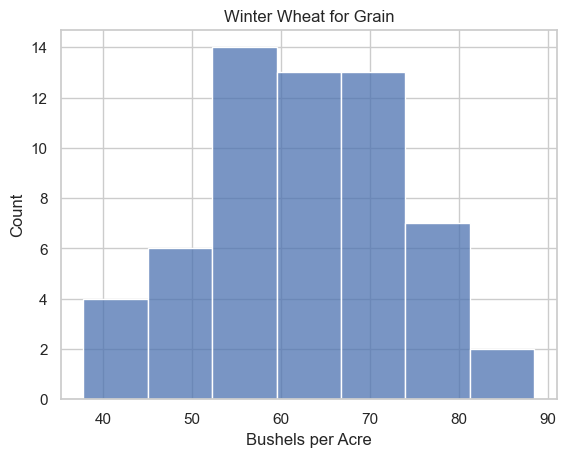